In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_context(font_scale=1.5)

df = pd.read_csv('../data/data.csv')

# remove informações que não são extraídas dos sinais de vibração
df.pop('rotacao_manual')
df.pop('severidade')

# exibe lista de características
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Columns: 110 entries, condicao to tg2_freqstat_rvf
dtypes: float64(109), object(1)
memory usage: 756.4+ KB


In [2]:
# exibe porção dos dados
df.head()

,condicao,rotacao_calc,ax1_1h,ax2_1h,rad1_1h,rad2_1h,tg1_1h,tg2_1h,ax1_2h,ax2_2h,...,rad1_freqstat_rmsf,rad2_freqstat_rmsf,tg1_freqstat_rmsf,tg2_freqstat_rmsf,ax1_freqstat_rvf,ax2_freqstat_rvf,rad1_freqstat_rvf,rad2_freqstat_rvf,tg1_freqstat_rvf,tg2_freqstat_rvf
0,horizontal-misalignment,12.0,0.078738,0.221200,0.006654,0.019212,0.002920,0.056890,0.015030,0.051852,...,994.441946,576.555280,1146.711087,720.417244,553.609683,366.108650,617.152712,475.548155,653.008680,582.086450
1,horizontal-misalignment,13.2,0.080740,0.226949,0.010259,0.010828,0.002189,0.059922,0.006250,0.083294,...,1071.699216,791.330286,1214.296423,825.388438,598.586959,435.130994,623.781488,575.895638,644.675030,628.811947
2,horizontal-misalignment,14.2,0.092599,0.269559,0.010088,0.012567,0.001595,0.070374,0.003847,0.100166,...,1113.749232,805.047072,1248.203488,889.080494,597.309366,434.144046,630.732462,578.373297,652.096296,654.005133
3,horizontal-misalignment,15.0,0.073945,0.261036,0.008649,0.012625,0.000961,0.061899,0.000689,0.076679,...,1116.381663,790.421021,1244.203292,895.672662,622.084462,429.322300,630.038256,573.347981,650.900267,657.516078
4,horizontal-misalignment,16.0,0.073207,0.298825,0.007493,0.015577,0.000483,0.070782,0.003335,0.078485,...,1146.744941,799.007171,1273.947865,951.543416,633.147946,460.930434,631.262211,578.856662,649.055371,684.909251


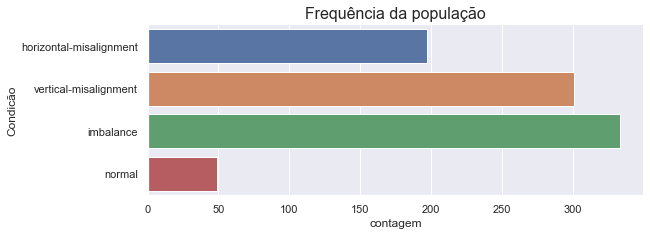

In [3]:
# plota distribuição da população
sns.catplot(data=df, y='condicao', kind="count", height=3, aspect=3)
plt.title('Frequência da população', fontsize=16)
plt.ylabel('Condicão')
plt.xlabel('contagem')
plt.show()

In [4]:
output_map = {
    'normal': 0,
    'imbalance': 1,
    'vertical-misalignment': 2,
    'horizontal-misalignment': 3,
}
output_remap = {v: k for k, v in output_map.items()}

# armazena output em um array
labels = np.array(df['condicao'].map(output_map))

# remove a coluna de labels do df original
df = df.drop('condicao', axis = 1)

In [5]:
columns = list(df.columns)
feat_type = {
    'harmonico 1': [col for col in columns if '1h'    in col],
    'harmonico 2': [col for col in columns if '2h'    in col],
    'harmonico 3': [col for col in columns if '3h'    in col],
    'harmonicos':  [col for col in columns if '1h'    in col or '2h' in col or '3h' in col],
    'entropia':    [col for col in columns if 'entr'  in col],
    'curtose':     [col for col in columns if 'kurt'  in col[-4:]],
    'RMS':         [col for col in columns if 'timestat_rms' in col],
    'estat_tempo': [col for col in columns if 'timestat'  in col],
    'estat_freq':  [col for col in columns if 'freqstat'  in col],
    'estatisticos':[col for col in columns if 'stat'  in col],
    'fase':        [col for col in columns if 'phase' in col[-5:]],
}

df_encoded_angles = pd.concat([
    df[feat_type['fase']].apply(np.sin).rename(columns = lambda x: x+'_sin'), 
    df[feat_type['fase']].apply(np.cos).rename(columns = lambda x: x+'_cos'),
], axis=1)
df = pd.concat([df, df_encoded_angles], axis=1)

columns = list(df.columns)
feat_type['fase_cos'] = [col for col in columns if 'phase_sin' in col or 'phase_cos' in col]

## Modelos

### Por Tipo de característica

In [6]:
feature_models = {
    ('Espectro', 'Ângulos de fase'):               list(feat_type['fase']+[]),
    ('Espectro', 'Seno e cosseno da fase'):        list(feat_type['fase_cos']),
    ('Espectro', 'Harmônicas'):                    list(feat_type['harmonicos']),
    ('Espectro', 'Harmônicas e s. c. da fase'):    list(feat_type['harmonicos'] + feat_type['fase_cos']),
    ('Estatístico', 'RMS'):                        list(feat_type['RMS']),
    ('Estatístico', 'RMS, Entropia e curtose'):    list(feat_type['RMS'] + feat_type['entropia'] + feat_type['curtose']),
    ('Estatístico', 'Estatísticas no tempo'):      list(feat_type['estat_tempo']),
    ('Estatístico', 'Estatísticas na frequência'): list(feat_type['estat_freq']),
    ('Estatístico', 'Estatísticas gerais'):        list(feat_type['estatisticos']),
    ('', 'Todas'):                                 list(df.columns)
}

for k, v in feature_models.items():
    if k[1] != 'Todas':
        v.append('rotacao_calc')

for col in feat_type['fase']:
    feature_models[('', 'Todas')].remove(col)

feature_models_data = {k: df[v] for k, v in feature_models.items() }

for k, v in feature_models_data.items():
    print(f'{k[1]} com {v.shape[1]} características')

Ângulos de fase com 7 características
Seno e cosseno da fase com 13 características
Harmônicas com 19 características
Harmônicas e s. c. da fase com 31 características
RMS com 7 características
RMS, Entropia e curtose com 19 características
Estatísticas no tempo com 67 características
Estatísticas na frequência com 19 características
Estatísticas gerais com 85 características
Todas com 115 características


In [7]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GroupKFold, StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

acc_list = []
# roc_auc_list = []
RS = 42

kfold = KFold(n_splits=8, shuffle=True, random_state=RS)

# SCV com one-vs-one
# clf = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced', probability=True, random_state=RS))
# clf_prob = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RS))

# linearSCV com one-vs-all
clf = make_pipeline(StandardScaler(), LinearSVC(class_weight='balanced', random_state=RS, max_iter=1e4))
clf_prob = make_pipeline(StandardScaler(), LinearSVC(class_weight='balanced', random_state=RS, max_iter=1e4))

for data in feature_models_data.values():
    evaluation = cross_validate(
        estimator= clf,
        X=data.values, y=labels,
        cv=kfold,
        scoring=['accuracy'])
    
    acc_list.append(evaluation['test_accuracy'])
#     roc_auc_list.append(evaluation['test_roc_auc_ovr'])

In [8]:
index = pd.MultiIndex.from_tuples(feature_models.keys(), names=['Tipo', 'Características'])
results = pd.DataFrame({
    'Nº': [v.shape[1] for v in feature_models_data.values()],
    'Acurácia': [f'{acc.mean():.3f} ± {acc.std():.3f}'.replace('.',',') for acc in acc_list],
}, index=index)

print(results.to_latex())
results

\begin{tabular}{llrl}
\toprule
            &       &   Nº &       Acurácia \\
Tipo & Características &      &                \\
\midrule
Espectro & Ângulos de fase &    7 &  0,724 ± 0,048 \\
            & Seno e cosseno da fase &   13 &  0,843 ± 0,024 \\
            & Harmônicas &   19 &  0,933 ± 0,012 \\
            & Harmônicas e s. c. da fase &   31 &  0,961 ± 0,016 \\
Estatístico & RMS &    7 &  0,781 ± 0,032 \\
            & RMS, Entropia e curtose &   19 &  0,907 ± 0,024 \\
            & Estatísticas no tempo &   67 &  0,963 ± 0,012 \\
            & Estatísticas na frequência &   19 &  0,972 ± 0,016 \\
            & Estatísticas gerais &   85 &  0,994 ± 0,006 \\
            & Todas &  115 &  0,994 ± 0,006 \\
\bottomrule
\end{tabular}



Nº       Acurácia
Tipo        Características                               
Espectro    Ângulos de fase               7  0,724 ± 0,048
            Seno e cosseno da fase       13  0,843 ± 0,024
            Harmônicas                   19  0,933 ± 0,012
            Harmônicas e s. c. da fase   31  0,961 ± 0,016
Estatístico RMS                           7  0,781 ± 0,032
            RMS, Entropia e curtose      19  0,907 ± 0,024
            Estatísticas no tempo        67  0,963 ± 0,012
            Estatísticas na frequência   19  0,972 ± 0,016
            Estatísticas gerais          85  0,994 ± 0,006
            Todas                       115  0,994 ± 0,006

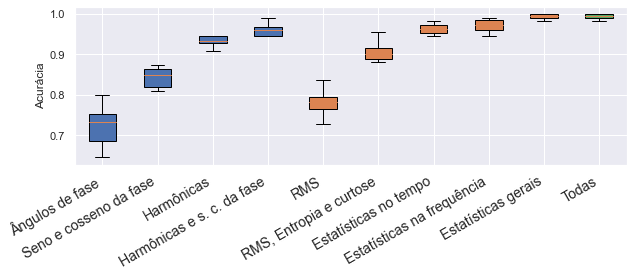

In [9]:
names = [k[1] for k in feature_models.keys()]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(acc_list, labels=names, patch_artist=True)
ax.set_ylabel("Acurácia")

colors = ['C0']*4 + ['C1']*5 + ['C2']

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    label.set_size(14)

plt.savefig('../redacao/figuras/acc_caracteristicas.pdf', bbox_inches='tight')
plt.tight_layout()

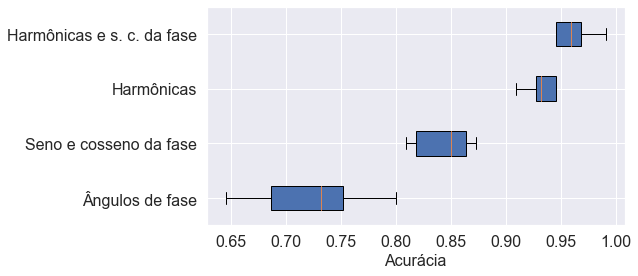

In [18]:
names = [k[1] for k in feature_models.keys()]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(acc_list[:4], labels=names[:4], patch_artist=True, vert=False)
ax.set_xlabel("Acurácia", size=16)

colors = ['C0']*4

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_ymajorticklabels():
    label.set_size(16)
for label in ax.get_xmajorticklabels():
    label.set_size(16)

plt.tight_layout()

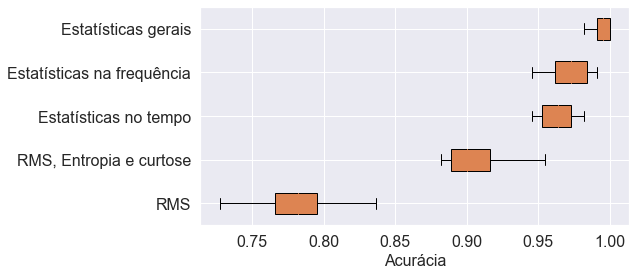

In [20]:
names = [k[1] for k in feature_models.keys()]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(acc_list[4:-1], labels=names[4:-1], patch_artist=True, vert=False)
ax.set_xlabel("Acurácia", size=16)

colors = ['C1']*5

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_ymajorticklabels():
    label.set_size(16)
for label in ax.get_xmajorticklabels():
    label.set_size(16)

plt.tight_layout()

### Por eixo

In [21]:
df_eixos = df.drop(feat_type['fase'], axis=1)
columns = list(df_eixos.columns)
columns.remove('rotacao_calc')

eixos = {
    'Axial 1':     [col for col in columns if 'ax1' in col],
    'Axial 2':     [col for col in columns if 'ax2' in col],
    'Axial duplo':       [col for col in columns if 'ax1' in col or 'ax2' in col],
    'Radial 1':    [col for col in columns if 'rad1' in col],    
    'Radial 2':    [col for col in columns if 'rad2' in col],
    'Radial duplo':      [col for col in columns if 'rad' in col],
    'Tangente 1':  [col for col in columns if 'tg1' in col],
    'Tangente 2':  [col for col in columns if 'tg2' in col],
    'Tangente duplo':    [col for col in columns if 'tg' in col],
    'Mancal 1 triax.':    [col for col in columns if '1_' in col],
    'Mancal 2 triax.':    [col for col in columns if '2_' in col],
    'Todos os eixos': columns
}

{k: v.append('rotacao_calc') for k, v in eixos.items()}

for k, v in eixos.items():
    print(f'{k} com {len(v)} características')

Axial 1 com 20 características
Axial 2 com 20 características
Axial duplo com 39 características
Radial 1 com 20 características
Radial 2 com 20 características
Radial duplo com 39 características
Tangente 1 com 20 características
Tangente 2 com 20 características
Tangente duplo com 39 características
Mancal 1 triax. com 58 características
Mancal 2 triax. com 58 características
Todos os eixos com 115 características


In [22]:
feature_models_eixos = {k: df_eixos[v] for k, v in eixos.items()}

acc_list = []

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

for data in feature_models_eixos.values():
    evaluation = cross_validate(
        estimator= clf,
        X=data.values, y=labels,
        cv=kfold,
        scoring=['accuracy'])
    
    acc_list.append(evaluation['test_accuracy'])

results = pd.DataFrame({
    'Acurácia': [f'{acc.mean():.3f} ± {acc.std():.3f}'.replace('.',',') for acc in acc_list],
    }, index=eixos)

print(results.to_latex())
results

\begin{tabular}{ll}
\toprule
{} &       Acurácia \\
\midrule
Axial 1         &  0,852 ± 0,024 \\
Axial 2         &  0,869 ± 0,028 \\
Axial duplo     &  0,956 ± 0,018 \\
Radial 1        &  0,889 ± 0,023 \\
Radial 2        &  0,830 ± 0,027 \\
Radial duplo    &  0,986 ± 0,010 \\
Tangente 1      &  0,823 ± 0,039 \\
Tangente 2      &  0,887 ± 0,016 \\
Tangente duplo  &  0,943 ± 0,019 \\
Mancal 1 triax. &  0,989 ± 0,008 \\
Mancal 2 triax. &  0,970 ± 0,016 \\
Todos os eixos  &  0,993 ± 0,008 \\
\bottomrule
\end{tabular}



,Acurácia
Axial 1,"0,852 ± 0,024"
Axial 2,"0,869 ± 0,028"
Axial duplo,"0,956 ± 0,018"
Radial 1,"0,889 ± 0,023"
Radial 2,"0,830 ± 0,027"
Radial duplo,"0,986 ± 0,010"
Tangente 1,"0,823 ± 0,039"
Tangente 2,"0,887 ± 0,016"
Tangente duplo,"0,943 ± 0,019"
Mancal 1 triax.,"0,989 ± 0,008"


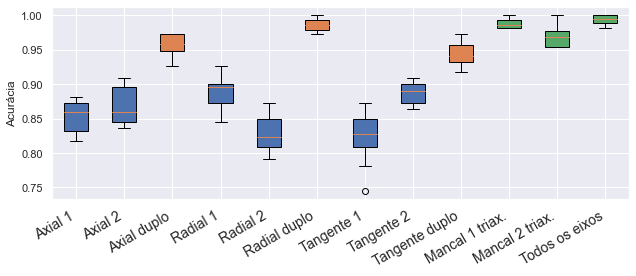

In [23]:
names = list(eixos.keys())

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(acc_list, labels=names, patch_artist=True)
ax.set_ylabel("Acurácia")

colors = ['C0']*2 + ['C1']*1 + ['C0']*2 + ['C1']*1 + ['C0']*2 + ['C1']*1 + ['C2']*3

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    label.set_size(14)

# plt.savefig('../redacao/figuras/acc_eixos.pdf', bbox_inches='tight')
plt.tight_layout()

In [24]:
names = list(eixos.keys())
sort = [0,3,6,9,1,4,7,10,2,5,8,11]
print('Original\n', names)
print('\nReordenado\n', [names[i] for i in sort])

Original
 ['Axial 1', 'Axial 2', 'Axial duplo', 'Radial 1', 'Radial 2', 'Radial duplo', 'Tangente 1', 'Tangente 2', 'Tangente duplo', 'Mancal 1 triax.', 'Mancal 2 triax.', 'Todos os eixos']

Reordenado
 ['Axial 1', 'Radial 1', 'Tangente 1', 'Mancal 1 triax.', 'Axial 2', 'Radial 2', 'Tangente 2', 'Mancal 2 triax.', 'Axial duplo', 'Radial duplo', 'Tangente duplo', 'Todos os eixos']


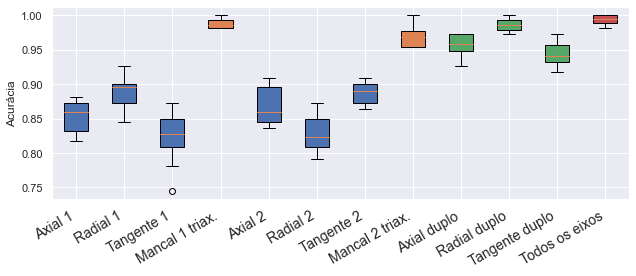

In [30]:
sorted_names = [names[i] for i in sort]
sorted_acc_list = [acc_list[i] for i in sort]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(sorted_acc_list, labels=sorted_names, patch_artist=True)
ax.set_ylabel("Acurácia")


colors = ['C0']*3 + ['C1']*1 + ['C0']*3 + ['C1']*1 + ['C2']*3 + ['C3']*1

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    label.set_size(14)

plt.savefig('../redacao/figuras/acc_eixos.pdf', bbox_inches='tight')
plt.tight_layout()

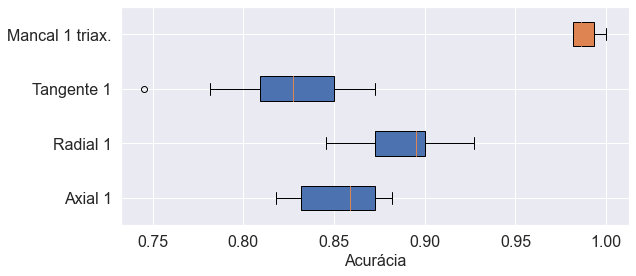

In [27]:
sorted_names = [names[i] for i in sort]
sorted_acc_list = [acc_list[i] for i in sort]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(sorted_acc_list[:4], labels=sorted_names[:4], patch_artist=True, vert=False)
ax.set_xlabel("Acurácia", size=16)


colors = ['C0']*3 + ['C1']*1

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_ymajorticklabels():
    label.set_size(16)
for label in ax.get_xmajorticklabels():
    label.set_size(16)

# plt.savefig('../redacao/figuras/acc_eixos.pdf', bbox_inches='tight')
plt.tight_layout()

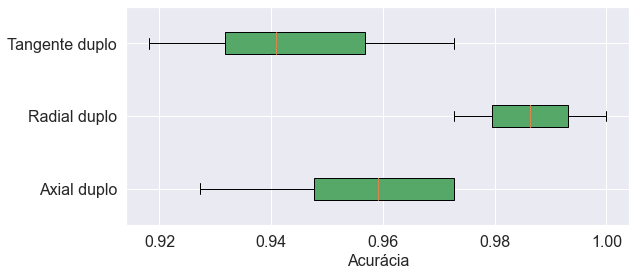

In [31]:
sorted_names = [names[i] for i in sort]
sorted_acc_list = [acc_list[i] for i in sort]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(sorted_acc_list[8:-1], labels=sorted_names[8:-1], patch_artist=True, vert=False)
ax.set_xlabel("Acurácia", size=16)


colors = ['C2']*3

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_ymajorticklabels():
    label.set_size(16)
for label in ax.get_xmajorticklabels():
    label.set_size(16)

# plt.savefig('../redacao/figuras/acc_eixos.pdf', bbox_inches='tight')
plt.tight_layout()

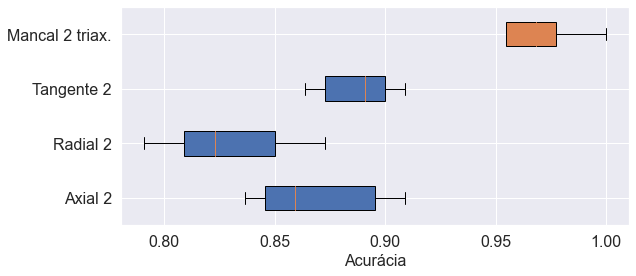

In [28]:
sorted_names = [names[i] for i in sort]
sorted_acc_list = [acc_list[i] for i in sort]

fig, ax = plt.subplots(figsize=(9,4))
bplot1 = ax.boxplot(sorted_acc_list[4:8], labels=sorted_names[4:8], patch_artist=True, vert=False)
ax.set_xlabel("Acurácia", size=16)


colors = ['C0']*3 + ['C1']*1

for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)

for label in ax.get_ymajorticklabels():
    label.set_size(16)
for label in ax.get_xmajorticklabels():
    label.set_size(16)

# plt.savefig('../redacao/figuras/acc_eixos.pdf', bbox_inches='tight')
plt.tight_layout()

### Por característica x eixo

In [ ]:
eixos_principais = {
    'Axial':       [col for col in columns if 'ax' in col],
    'Radial':      [col for col in columns if 'rad' in col],
    'Tangente':    [col for col in columns if 'tg' in col],
}

{k: v.append('rotacao_calc') for k, v in eixos_principais.items()}

acc_mean = []
acc_std = []

clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

i=0
for feat_type in feature_models.values():
    acc_mean.append([])
    acc_std.append([])
    for eixo in eixos_principais.values():
        df_slice = list(set(feat_type) & set(eixo))
        evaluation = cross_validate(
            estimator=clf,
            X=df[df_slice].values, y=labels,
            cv=kfold,
            scoring=['balanced_accuracy'])

        acc_mean[i].append(evaluation['test_balanced_accuracy'].mean())
        acc_std[i].append(evaluation['test_balanced_accuracy'].std())
    i+=1

In [ ]:
cross_results = pd.DataFrame(acc_mean, index=index, columns=eixos_principais.keys())
# cross_results['Acurácia média'] = cross_results.mean(axis=1)
cross_results

### Train-Test split

#### Espectro

In [168]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(feature_models_data[('Espectro', 'Harmônicas e s. c. da fase')], labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [169]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

traducao = {
    'normal': 'Normal',
    'imbalance': 'Desbalanceamento',
    'vertical-misalignment': 'Desal. Vertical',
    'horizontal-misalignment': 'Desal. Horizontal',
}

condicoes = [traducao[k] for k in output_map.keys()]


matrix = confusion_matrix(y_test, y_predicted, normalize='true')
matrix_df = pd.DataFrame(matrix*100, index=condicoes, columns=condicoes).rename_axis("Real").rename_axis("Predito", axis=1)

print(matrix_df.to_latex(float_format="%.1f", decimal=','))
matrix_df

\begin{tabular}{lrrrr}
\toprule
Predito &  Normal &  Desbalanceamento &  Desal. Vertical &  Desal. Horizontal \\
Real              &         &                   &                  &                    \\
\midrule
Normal            &    91,7 &               0,0 &              0,0 &                8,3 \\
Desbalanceamento  &     0,0 &             100,0 &              0,0 &                0,0 \\
Desal. Vertical   &     0,0 &               0,0 &            100,0 &                0,0 \\
Desal. Horizontal &     6,1 &               0,0 &              0,0 &               93,9 \\
\bottomrule
\end{tabular}



Predito,Normal,Desbalanceamento,Desal. Vertical,Desal. Horizontal
Real,,,,
Normal,91.666667,0.0,0.0,8.333333
Desbalanceamento,0.000000,100.0,0.0,0.000000
Desal. Vertical,0.000000,0.0,100.0,0.000000
Desal. Horizontal,6.122449,0.0,0.0,93.877551


#### Estatísticas

In [170]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(feature_models_data[('Estatístico', 'Estatísticas gerais')], labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [171]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

traducao = {
    'normal': 'Normal',
    'imbalance': 'Desbalanceamento',
    'vertical-misalignment': 'Desal. Vertical',
    'horizontal-misalignment': 'Desal. Horizontal',
}

condicoes = [traducao[k] for k in output_map.keys()]


matrix = confusion_matrix(y_test, y_predicted, normalize='true')
matrix_df = pd.DataFrame(matrix*100, index=condicoes)

print(matrix_df.to_latex(float_format="%.1f", decimal=','))
matrix_df

\begin{tabular}{lrrrr}
\toprule
{} &     0 &     1 &    2 &     3 \\
\midrule
Normal            & 100,0 &   0,0 &  0,0 &   0,0 \\
Desbalanceamento  &   0,0 & 100,0 &  0,0 &   0,0 \\
Desal. Vertical   &   0,0 &   1,3 & 96,1 &   2,6 \\
Desal. Horizontal &   0,0 &   0,0 &  0,0 & 100,0 \\
\bottomrule
\end{tabular}



,0,1,2,3
Normal,100.0,0.000000,0.000000,0.000000
Desbalanceamento,0.0,100.000000,0.000000,0.000000
Desal. Vertical,0.0,1.315789,96.052632,2.631579
Desal. Horizontal,0.0,0.000000,0.000000,100.000000


#### Todas

In [172]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(feature_models_data[('', 'Todas')], labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [173]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

traducao = {
    'normal': 'Normal',
    'imbalance': 'Desbalanceamento',
    'vertical-misalignment': 'Desal. Vertical',
    'horizontal-misalignment': 'Desal. Horizontal',
}

condicoes = [traducao[k] for k in output_map.keys()]


matrix = confusion_matrix(y_test, y_predicted, normalize='true')
matrix_df = pd.DataFrame(matrix*100, index=condicoes)

print(matrix_df.to_latex(float_format="%.1f", decimal=','))
matrix_df

\begin{tabular}{lrrrr}
\toprule
{} &     0 &     1 &    2 &     3 \\
\midrule
Normal            & 100,0 &   0,0 &  0,0 &   0,0 \\
Desbalanceamento  &   0,0 & 100,0 &  0,0 &   0,0 \\
Desal. Vertical   &   1,3 &   0,0 & 97,4 &   1,3 \\
Desal. Horizontal &   0,0 &   0,0 &  0,0 & 100,0 \\
\bottomrule
\end{tabular}



,0,1,2,3
Normal,100.000000,0.0,0.000000,0.000000
Desbalanceamento,0.000000,100.0,0.000000,0.000000
Desal. Vertical,1.315789,0.0,97.368421,1.315789
Desal. Horizontal,0.000000,0.0,0.000000,100.000000


#### Triaxial, mancal 1

In [174]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(feature_models_eixos['Mancal 1 triax.'], labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [175]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

traducao = {
    'normal': 'Normal',
    'imbalance': 'Desbalanceamento',
    'vertical-misalignment': 'Desal. Vertical',
    'horizontal-misalignment': 'Desal. Horizontal',
}

condicoes = [traducao[k] for k in output_map.keys()]


matrix = confusion_matrix(y_test, y_predicted, normalize='true')
matrix_df = pd.DataFrame(matrix*100, index=condicoes)

print(matrix_df.to_latex(float_format="%.1f", decimal=','))
matrix_df

\begin{tabular}{lrrrr}
\toprule
{} &     0 &     1 &    2 &    3 \\
\midrule
Normal            & 100,0 &   0,0 &  0,0 &  0,0 \\
Desbalanceamento  &   0,0 & 100,0 &  0,0 &  0,0 \\
Desal. Vertical   &   0,0 &   0,0 & 98,7 &  1,3 \\
Desal. Horizontal &   0,0 &   2,0 &  6,1 & 91,8 \\
\bottomrule
\end{tabular}



,0,1,2,3
Normal,100.0,0.000000,0.000000,0.000000
Desbalanceamento,0.0,100.000000,0.000000,0.000000
Desal. Vertical,0.0,0.000000,98.684211,1.315789
Desal. Horizontal,0.0,2.040816,6.122449,91.836735


#### Par de mancais radiais

In [176]:
from sklearn.model_selection import train_test_split

# separa os conjuntos de treino e teste com amostragem estratificada,
# logo, mantendo a proporção para cada tipo de defeito
X_train, X_test, y_train, y_test = train_test_split(feature_models_eixos['Radial duplo'], labels, test_size = 0.25, stratify=labels, random_state=42) 

clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [177]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

traducao = {
    'normal': 'Normal',
    'imbalance': 'Desbalanceamento',
    'vertical-misalignment': 'Desal. Vertical',
    'horizontal-misalignment': 'Desal. Horizontal',
}

condicoes = [traducao[k] for k in output_map.keys()]


matrix = confusion_matrix(y_test, y_predicted, normalize='true')
matrix_df = pd.DataFrame(matrix*100, index=condicoes)

print(matrix_df.to_latex(float_format="%.1f", decimal=','))
matrix_df

\begin{tabular}{lrrrr}
\toprule
{} &     0 &    1 &    2 &    3 \\
\midrule
Normal            & 100,0 &  0,0 &  0,0 &  0,0 \\
Desbalanceamento  &   0,0 & 98,8 &  1,2 &  0,0 \\
Desal. Vertical   &   1,3 &  1,3 & 96,1 &  1,3 \\
Desal. Horizontal &   2,0 &  0,0 &  0,0 & 98,0 \\
\bottomrule
\end{tabular}



,0,1,2,3
Normal,100.000000,0.000000,0.000000,0.000000
Desbalanceamento,0.000000,98.795181,1.204819,0.000000
Desal. Vertical,1.315789,1.315789,96.052632,1.315789
Desal. Horizontal,2.040816,0.000000,0.000000,97.959184


### Curva ROC

In [ ]:
from sklearn.preprocessing import label_binarize

y = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = 4

# Compute ROC curve and ROC area for each class
y_score = clf.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(5,5))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='blue')

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='darkorange')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## Seleção de características

### SFS

In [ ]:
# método guloso, demora DIAS para computar
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(estimator=clf, cv=kfold,
              scoring='accuracy', n_features_to_select=2)
sfs.fit(df, labels)
df.columns[sfs.support_]

### K-Best
Estatística univariada baseada em: chi2, f_classif, mutual_info_classif

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

min_features_to_select = 1  # Minimum number of features to consider

kbest = SelectKBest(score_func=f_classif , k='all')
kbest.fit(df, labels)

sorted_features = pd.Series(kbest.scores_, index=df.columns).sort_values(ascending=False)
sorted_features[:20]

In [ ]:
X = pd.DataFrame()
scores_list = []
for feature in sorted_features.index:
    X = pd.concat([X, df[feature]], axis=1)
    scores = cross_val_score(clf, X, labels, scoring='accuracy', cv=kfold)
    scores_list.append(scores)
    

In [ ]:
scores_df = pd.DataFrame(scores_list)
# scores_df['feature'] = sorted_features.index
scores_df = scores_df.reset_index().melt(id_vars='index')
scores_df
sns.relplot(data=scores_df, x='index', y='value', kind='line', aspect=2)

## Interpretabilidade do modelo

### Decision Boundary 
"Histogram of projects" by Cherkassky, Vladimir & Dhar, Sauptik. (2010). Simple Method for Interpretation of High-Dimensional Nonlinear SVM Classification Models.. 267–272.

In [ ]:
decision_func = pd.DataFrame(clf.decision_function(X_test), columns=condicoes)
decision_func['true_label'] = [output_remap[out] for out in y_test]
decision_func.hist(bins=30, histtype='stepfilled', by='true_label', alpha = 0.7, legend=True, figsize=(10,10))
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_sorted_idx][-10:].T, vert=False,
            labels=df.columns[perm_sorted_idx][-10:])
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

In [ ]:
tree_importance_sorted_idx = np.argsort(rf_clf.feature_importances_)
tree_indices = np.arange(0, len(rf_clf.feature_importances_)) + 0.5

fig, ax = plt.subplots(1, 1, figsize=(6, 24))
ax.barh(tree_indices, rf_clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax.set_yticklabels(df.columns[tree_importance_sorted_idx])
ax.set_yticks(tree_indices)
ax.set_ylim((0, len(rf_clf.feature_importances_)))

In [ ]:
import shap 

# print the JS visualization code to the notebook
shap.initjs()

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(df)

In [ ]:
shap.summary_plot(shap_values, df)